In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
import uuid
import time

# 生成fake行情数据


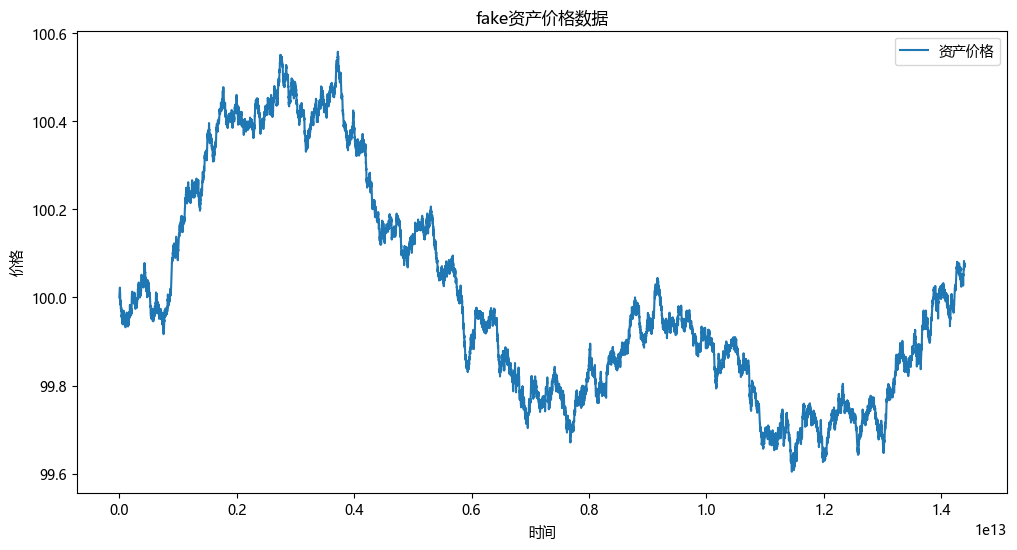

In [2]:
def generate_path(S0, mu, sigma, hours, steps_per_hour):
    """
    asset process: GBM
    """
    np.random.seed(42)
    
    total_steps = hours * steps_per_hour
    dt = 1 / steps_per_hour
    
    # BM
    z = np.random.standard_normal(total_steps-1)
    S = np.zeros(total_steps)
    S[0] = S0
    S[1:] = S[0] + sigma * np.sqrt(dt) * z.cumsum(axis=0)
    
#     # GBM
#     t = np.linspace(0, hours, total_steps)
#     W = np.random.standard_normal(size=total_steps)
#     W = np.cumsum(W) * np.sqrt(dt)
#     X = (mu - 0.5 * sigma**2) * t + sigma * W
#     S = S0 * np.exp(X)
    
    # 用 timedelta_range 生成时间索引
    time_index = pd.timedelta_range(start='0s', periods=total_steps, freq=f'{int(3600/steps_per_hour)}S')
    return pd.Series(S, index=time_index)

# 每秒生成一个数据
price_series = generate_path(S0=100, mu=0.1, sigma=0.3, hours=4, steps_per_hour=3600)
plt.figure(figsize=(12,6))
plt.plot(price_series.index, price_series, label='资产价格')
plt.title('fake资产价格数据')
plt.xlabel('时间')
plt.ylabel('价格')
plt.legend()
plt.show()

In [3]:
def generate_spread(base_price):
    '''
    生成买卖价差：波动率越高价差越大；数值为1+波动率因素；最小为0.5；最大为3
    '''
    volatility = base_price.pct_change().rolling(10).std()
    return np.clip(1 + volatility*100, 0.5, 3.0)

spread_series = generate_spread(price_series)
spread_series = spread_series.fillna(spread_series.mean())  # 初始10期用均值填充
spread_series

0 days 00:00:00    1.004889
0 days 00:00:01    1.004889
0 days 00:00:02    1.004889
0 days 00:00:03    1.004889
0 days 00:00:04    1.004889
                     ...   
0 days 03:59:55    1.003456
0 days 03:59:56    1.003424
0 days 03:59:57    1.004167
0 days 03:59:58    1.004442
0 days 03:59:59    1.004467
Freq: S, Length: 14400, dtype: float64

In [4]:
# 不需生成完整订单簿，在AS模型中我们只关注最优买卖价
def generate_order_book_AS(current_price, spread):
    ask_price = current_price + spread/2
    bid_price = current_price - spread/2
    return ask_price, bid_price

ask_price, bid_price = generate_order_book_AS(price_series, spread_series)

# 用法示例
market_data = pd.DataFrame({
    'mid': price_series,
    'ask': ask_price,
    'bid': bid_price
})

market_data.head()

,mid,ask,bid
0 days 00:00:00,100.000000,100.502444,99.497556
0 days 00:00:01,100.002484,100.504928,99.500039
0 days 00:00:02,100.001792,100.504237,99.499348
0 days 00:00:03,100.005031,100.507475,99.502586
0 days 00:00:04,100.012646,100.515090,99.510201


# AS 模型

In [5]:
class AvellanedaStoikovStrategy:
    def __init__(self,
                 risk_aversion,
                 volatility,
                 kappa,
                 max_inventory,
                 time_window,
                 N):
        """
        risk_aversion: 风险厌恶系数 gamma
        volatility: 市场波动率 sigma
        kappa: 委托到达速率控制参数
        max_inventory: 最大净持仓
        time_window: 订单超时（秒）
        """
        self.gamma = risk_aversion
        self.sigma = volatility
        self.kappa = kappa    # order book liquidity, 数值越大，越难成交
        self.max_inventory = max_inventory
        self.time_window = time_window
        self.N = N
        self.dt = 1/N
        
        # 运行时状态
        self.inventory = 0
        self.cash = 0.0
        self.initial_cash = 0.0  # 可设为初始资金，比如 0
        self.pnl_history = []    # 每次行情更新时记录 (timestamp, cash, inv, mtm_pnl, total_pnl)
        self.order_history = []
        self.active_orders = {}
        self.count = 0
        self.reserve_price = 0
        
        
    def calculate_reservation_price(self, mid_price, current_ts):
        """无差异价格 r* = m − γ σ² q"""
        return mid_price - self.gamma * (self.sigma**2) * self.inventory * (1 - self.dt * current_ts)    # total time by default=1, limited time horizon

    def calculate_spread(self):
        """动态最优价差 δ* = (2/γ)·ln(1 + γ/κ) + γ σ² |q|"""
        base = (2/self.gamma) * np.log(1 + self.gamma/self.kappa)
        return base + self.gamma * (self.sigma**2) * abs(self.inventory)

    def place_orders(self, timestamp, mid_price, bid_price, ask_price, current_ts):
        """
        在当前无差异价 r* 两侧下买卖限价单：
          bid_price  = r* − reserve_spread*/2
          ask_price  = r* + reserve_spread*/2
        并记录
        """
        self.reserve_price = self.calculate_reservation_price(mid_price, current_ts)
        reserve_spread = self.calculate_spread()
        self.opt_bid = self.reserve_price - reserve_spread/2
        self.opt_ask = self.reserve_price + reserve_spread/2
            
        for side, price in [('buy', self.opt_bid), ('sell', self.opt_ask)]:
            # 限制最大库存
            if side == 'buy' and self.inventory >= self.max_inventory:
                continue
            if side == 'sell' and self.inventory <= -self.max_inventory:
                continue

            order_id = str(uuid.uuid4())
            order = {
                'order_id': order_id,
                'timestamp': timestamp,
                'type': 'limit',
                'side': side,
                'price': price,
                'size': 1,                            # 可以改成可变size
                'status': 'active'
            }
            self.active_orders[order_id] = order
            self.order_history.append({**order})
        
    def cancel_expired_orders(self, current_ts):
        """
        撤销挂单时间超过 self.time_window 的订单
        """
        to_cancel = []
        for oid, o in self.active_orders.items():
            if current_ts - o['timestamp'] > self.time_window:
                to_cancel.append(oid)
        for oid in to_cancel:
            o = self.active_orders.pop(oid)
            o['status'] = 'cancelled'
            o['cancel_ts'] = current_ts
            self.order_history.append(o)
    
    def match_orders(self, bid_price, ask_price, current_ts):
        """
        简单撮合：如果有买单 price >= market ask，或卖单 price <= market bid，
        则视为成交。成交时更新 inventory 和 cash。
        """
          
        M = ask_price - bid_price
        A = 1.*hours*steps_per_hour/np.exp(self.kappa * M/2)   # 1./dt/np.exp(k*M/2) where dt=1/4/3600
        to_fill = []
        for oid, o in self.active_orders.items():
            if o['side']=='buy':
                optimal_distance_bid = self.gamma * abs(self.inventory) * (self.sigma**2) + (1/self.gamma) * np.log(1 + (self.gamma/self.kappa))
                lambda_bid = A * np.exp(-self.kappa * optimal_distance_bid)    # exponential arrival rates 
                bid_probability = 1 - np.exp(-lambda_bid * (current_ts - o['timestamp'])/hours/steps_per_hour)    # probability of bid and ask    
                if np.random.rand() < bid_probability:
                    to_fill.append(oid)
            if o['side']=='sell':
                optimal_distance_ask = -self.gamma * abs(self.inventory) * (self.sigma**2) + (1/self.gamma) * np.log(1 + (self.gamma/self.kappa))
                lambda_ask = A * np.exp(-self.kappa * optimal_distance_ask)
                ask_probability = 1 - np.exp(-lambda_ask * (current_ts - o['timestamp'])/hours/steps_per_hour)
                if np.random.rand() < ask_probability:
                    to_fill.append(oid)
                    
        for oid in to_fill:
            o = self.active_orders.pop(oid)
            o['status'] = 'filled'
            o['fill_ts'] = current_ts
            size = o['size']
            price = o['price']
            # 更新持仓和现金：买入 -> 持仓+，现金-；卖出 -> 持仓-，现金+
            if o['side']=='buy':
                self.inventory += size
                self.cash -= price * size
            else:
                self.inventory -= size
                self.cash += price * size
            self.order_history.append(o)

    def record_pnl(self, timestamp, mid_price, bid_price, ask_price):
        """
        1) 未实现盈亏 (mark-to-market): inventory * mid_price
        2) 已实现盈亏: cash - initial_cash
        3) 总盈亏: 已实现 + 未实现
        """
        unrealized = self.inventory * mid_price
        realized = self.cash - self.initial_cash
        total = realized + unrealized
        self.pnl_history.append({
            'timestamp': timestamp,
            'mid_price': mid_price,
            'reservation price': self.reserve_price,
            'best_bid': bid_price,
            'best_ask': ask_price,
            'opt_bid': self.opt_bid,
            'opt_ask': self.opt_ask,
            'realized_pnl': realized,
            'unrealized_pnl': unrealized,
            'total_pnl': total,
            'inventory': self.inventory,
            'cash': self.cash
        })

    def on_market_data(self, timestamp, mid_price, bid_price, ask_price, check_performance=False):
        # 1) 撤超时
        self.cancel_expired_orders(timestamp)
        # 2) 下新单
        self.place_orders(timestamp, mid_price, bid_price, ask_price,  timestamp)
        # 3) 模拟撮合
        self.match_orders(bid_price, ask_price, timestamp)
        # 4) 记录 pnl
        self.record_pnl(timestamp, mid_price, bid_price, ask_price)

In [29]:
if __name__ == '__main__':
    
    S0 = 100
    mu = 2
    sigma = 2
    hours = 1
    steps_per_hour = 3600 # 数据频率为 1s一个数据
    
    price_series = generate_path(S0, mu, sigma, hours, steps_per_hour)
    spread_series = generate_spread(price_series)
    spread_series = spread_series.fillna(spread_series.mean())  # 初始10期用均值填充
    
    ask_price, bid_price = generate_order_book_AS(price_series, spread_series)

    market_data = pd.DataFrame({
    'mid': price_series,
    'ask': ask_price,
    'bid': bid_price
    })
    
    strat = AvellanedaStoikovStrategy(
        risk_aversion=0.005,    # gamma: inventory Risk aversion
        volatility=sigma,
        kappa=1.5,     # order book liquidity, 数值越大，越难成交
        max_inventory=10,
        time_window=10.0,
        N = hours * steps_per_hour
    )
    # 重置 initial_cash（例如 0）
    strat.initial_cash = strat.cash

    # 假设 market_data 有 mid/ask/bid，index 为秒级 timestamp
    df = market_data.reset_index().rename(columns={'index':'ts'})
    for _, row in df.iterrows():
        ts = row['ts'].total_seconds()
        strat.on_market_data(
            timestamp=ts,
            mid_price=row['mid'],
            bid_price=row['bid'],
            ask_price=row['ask']
        )

    # 最后把 pnl_history 转成 DataFrame
    pnl_df = pd.DataFrame(strat.pnl_history)
    print(pnl_df.head(10))
    print("最终总 P&L:", pnl_df['total_pnl'].iloc[-1])

   timestamp   mid_price  reservation price   best_bid    best_ask    opt_bid  \
0        0.0  100.000000         100.000000  99.484058  100.515942  99.334442   
1        1.0  100.016557         100.016557  99.500615  100.532499  99.350999   
2        2.0  100.011948          99.991959  99.496006  100.527891  99.316401   
3        3.0  100.033538         100.033538  99.517596  100.549480  99.367980   
4        4.0  100.084306         100.064328  99.568363  100.600248  99.388770   
5        5.0  100.076500         100.076500  99.560558  100.592443  99.410942   
6        6.0  100.068696         100.048729  99.552754  100.584638  99.373171   
7        7.0  100.121336         100.121336  99.605394  100.637279  99.455778   
8        8.0  100.146918         100.107006  99.630975  100.662860  99.421448   
9        9.0  100.131268         100.131268  99.615326  100.647211  99.465710   

      opt_ask  realized_pnl  unrealized_pnl  total_pnl  inventory        cash  
0  100.665558      0.000000 

## 结果分析

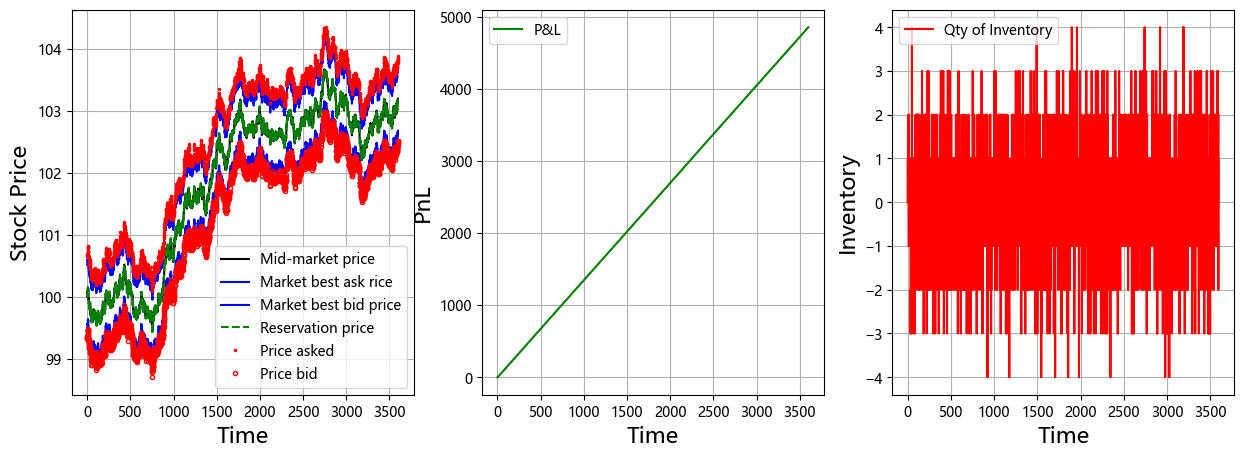

In [30]:
# save plot
f = plt.figure(figsize=(15, 5))
f.add_subplot(1,3, 1)
plt.plot(pnl_df.index, pnl_df['mid_price'], color='black', label='Mid-market price')
plt.plot(pnl_df.index, pnl_df['best_ask'], color='blue', label='Market best ask rice')
plt.plot(pnl_df.index, pnl_df['best_bid'], color='blue', label='Market best bid price')
plt.plot(pnl_df.index, pnl_df['reservation price'], color='green', linestyle='dashed', label='Reservation price')
plt.plot(pnl_df.index, pnl_df['opt_ask'], color='red', linestyle='', marker='.', label='Price asked', markersize='3')
plt.plot(pnl_df.index, pnl_df['opt_bid'], color='red', linestyle='', marker='o', markerfacecolor = 'none',label='Price bid', markersize='3')
plt.xlabel('Time', fontsize=16)
plt.ylabel('Stock Price', fontsize=16)
plt.grid(True)
plt.legend()

f.add_subplot(1,3, 2)
plt.plot(pnl_df.index, pnl_df['total_pnl'], color='green', label='P&L')
plt.xlabel('Time', fontsize=16)
plt.ylabel('PnL', fontsize=16)
plt.grid(True)
plt.legend()

f.add_subplot(1,3, 3)
plt.plot(pnl_df.index, pnl_df['inventory'], color='red', label='Qty of Inventory')
plt.xlabel('Time', fontsize=16)
plt.ylabel('Inventory', fontsize=16)
plt.grid(True)
plt.legend()

# f.savefig(f'result_{mode}.png')
plt.show()

## 优化建议

**1： 库存控制改进** 

实现更复杂的库存管理策略。比如：不是简单设置库存上限，而是将库存量限制细化为多头库存量限制和空头库存量限制。同时模型假设持续交易，不存在收盘，实际情况下当考虑收盘的时候，应添加库存衰减机制，使库存随时间自然减少。

$$
r(s, q, t) = s - q \gamma \sigma^2 (T - t)
$$

**2：考虑交易对市场价格的冲击效应。**

当前demo的一个假设是:主体作为市场价格接受者，且市场流动性充足，主体的交易不影响市场最优报价，同时主体的历史挂单在对应市场价格上都能充分成交；成交价格为市场价格而不是做市商报价。实际情况会比模型更复杂。


**3：动态调整参数**

**策略对参数的变化极度敏感，稍有变化则会导致策略亏损**，原因在于模拟历史数据的时候较为粗糙，没能很好地模拟做市商面对的高流动性环境。

风险厌恶系数(γ)、基础价差(spread_base)、波动率(σ)、订单超时撤单窗口（time_window）需要根据市场条件动态调整。

1)风险厌恶系数(γ): 回测校正，取收益最大时的γ

2)基础价差(spread_base)：结合市场流动性变化调整基础价差(spread_base)，由完整的AS公式给出：

$$
\delta^a + \delta^b = \gamma \sigma^2 (T - t) + \frac{2}{\gamma} \ln\left(1 + \frac{\gamma}{\kappa}\right)
$$

其中kappa是订单密度参数，反映市场流动性

3)波动率(σ)：使用Garch时间序列预测方法动态调整σ；

**4：实现更精细的订单簿管理**

考虑挂单深度。现在是每个时间点双向挂1单，之后可以结合不同情况挂不同的单（结构，数量）

**5：实现更复杂的止损策略**

添加市场异常波动检测机制。当前撮合方法在市场非震荡（单边市）的时候表现较差。

**6.代码性能优化**

优化demo的代码结构，支持更高频次和多策略的交易。比如对订单簿构建 class；为了简化代码，demo中的撮合机制process_orders写在了class AvellanedaStoikovStrategy下，
```python
class AvellanedaStoikovStrategy:
    ...
    def process_orders(self, market_bid_price, market_ask_price, current_time):
        ...
 ```

实际应该单独写一个类，作为撮合机制,如

```python
class OrderMatching
    def __init__(self):
        self.bids = [] 
        self.asks = []
    def add_order(self):
        ...
    def match_orders(self):
        ...
 ```

